### Klasyfikacja pojedynczych znaków
Pierwszym zagadnieniem jakie poruszym jest rozpoznawanie cyfr zapisanych pisemem odręcznym. 


Rozpoczynam od załadowania niezbędnych bibliotek. Będziemy używać biblioteki "Mxnet" do trenowania sieci neuronowej, która posłuży do rozpoznawania odręcznych cyfr pochodzących ze zboiru MNIST.

In [2]:
import mxnet as mx

ModuleNotFoundError: No module named 'mxnet'

#### Przygotowanie zbioru danych

Gdy mamy już załadowane niezbędne biblioteki, możemy przejśc dalej do przygotowania danych, których będziemy używać. Rozpoczynamy od pobrania zbioru danych mnist i podzałem na cześć testową oraz terningową.

In [1]:
# Fixing the random seed
mx.random.seed(42)

mnist = mx.test_utils.get_mnist()
batch_size = 100
train_data = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_data = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

NameError: name 'mx' is not defined

Omówimy kilka podejść do wykonania zadania rozpoznawania cyfr odręcznych. Pierwsze podejście wykorzystuje tradycyjną architekturę głębokich sieci neuronowych o nazwie Perceptron wielowarstwowy (MLP). Omówimy jego wady i wykorzystamy to jako motywację do wprowadzenia drugiego, bardziej zaawansowanego podejścia o nazwie Convolution Neural Network (CNN), które okazało się bardzo dobrze sprawdzać się w zadaniach klasyfikacji obrazów.

Teraz zaimportujmy wymagane moduły nn

In [5]:
from __future__ import print_function
from mxnet import gluon
from mxnet.gluon import nn
from mxnet import autograd as ag

ModuleNotFoundError: No module named 'mxnet'

Zdefiniuj sieć: Perceptron wielowarstwowy
Pierwsze podejście wykorzystuje wielowarstwowy perceptron do rozwiązania tego problemu. Zdefiniujemy MLP przy użyciu imperatywnego podejścia MXNet.

MLP składają się z kilku w pełni połączonych warstw. W pełni połączona warstwa lub w skrócie warstwa FC to taka, w której każdy neuron w warstwie jest połączony z każdym neuronem w poprzedniej warstwie. Z perspektywy algebry liniowej warstwa FC stosuje transformację afiniczną do macierzy wejściowej n x m X i generuje macierz Y o rozmiarze n x k, gdzie k jest liczbą neuronów w warstwie FC. k jest również określane jako ukryty rozmiar. Wyjście Y jest obliczane zgodnie z równaniem Y = W X + b. Warstwa FC ma dwa parametry, których można się nauczyć, macierz wag m x k ​​W i wektor odchylenia b m x 1 .

W MLP wyjścia większości warstw FC są podawane do funkcji aktywacji, która stosuje nieliniowość elementową. Ten krok jest krytyczny i daje sieciom neuronowym możliwość klasyfikowania danych wejściowych, które nie są liniowo rozdzielone. Typowe wybory dla funkcji aktywacji to sigmoid, tanh i rektyfikowana jednostka liniowa (ReLU). W tym przykładzie użyjemy funkcji aktywacji ReLU, która ma kilka pożądanych właściwości i jest zwykle uważana za wybór domyślny.

Poniższy kod deklaruje trzy w pełni połączone warstwy po 128, 64 i 10 neuronów każda. Ostatnia w pełni połączona warstwa często ma swój ukryty rozmiar równy liczbie klas wyjściowych w zestawie danych. Co więcej, te warstwy FC wykorzystują aktywację ReLU do przeprowadzania transformacji ReLU z uwzględnieniem elementów na wyjściu warstwy FC.

W tym celu użyjemy warstwy typu Sequential. To po prostu liniowy stos warstw sieci neuronowych. nn.Gęste warstwy to nic innego jak w pełni połączone warstwy, które omówiliśmy powyżej.

In [6]:
# define network
net = nn.Sequential()
with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))

NameError: name 'nn' is not defined

Zainicjuj parametry i optymalizator
Poniższy kod źródłowy inicjalizuje wszystkie parametry otrzymane z parametru dict przy użyciu inicjatora Xavier do trenowania sieci MLP, którą zdefiniowaliśmy powyżej.

Do naszego szkolenia wykorzystamy optymalizator stochastycznego gradientu (SGD). W szczególności będziemy używać mini-partii SGD. Standardowy SGD przetwarza dane o pociągach po jednym przykładzie na raz. W praktyce jest to bardzo powolne i można przyspieszyć proces, przetwarzając przykłady w małych partiach. W takim przypadku nasza wielkość partii będzie wynosić 100, co jest rozsądnym wyborem. Innym parametrem, który tutaj wybieramy, jest szybkość uczenia się, która kontroluje wielkość kroku, jaki optymalizator przyjmuje w poszukiwaniu rozwiązania. Wybierzemy współczynnik uczenia się 0,02, ponownie rozsądny wybór. Ustawienia, takie jak wielkość partii i szybkość uczenia się, są zwykle nazywane hiperparametrami. Jakie wartości im nadajemy, mogą mieć ogromny wpływ na wyniki treningowe.

Użyjemy klasy Trainer, aby zastosować optymalizator SGD na zainicjowanych parametrach.

In [7]:
gpus = mx.test_utils.list_gpus()
ctx =  [mx.gpu()] if gpus else [mx.cpu(0), mx.cpu(1)]
net.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.02})

NameError: name 'mx' is not defined

Trenuj sieć¶
Zazwyczaj uczenie prowadzi się do zbieżności, co oznacza, że ​​na podstawie danych pociągu nauczyliśmy się dobrego zestawu parametrów modelu (wagi + obciążenia). Na potrzeby tego samouczka przeprowadzimy trening przez 10 epok i zatrzymamy się. Epoka to jedno pełne przejście przez wszystkie dane pociągu.

Do szkolenia podejmiemy następujące kroki:

Zdefiniuj metrykę oceny dokładności na podstawie danych uczących.

Zapętlaj wejścia dla każdej epoki.

Przekaż dane wejściowe przez sieć, aby uzyskać dane wyjściowe.

Straty obliczeniowe z danymi wyjściowymi i etykietą w zakresie rekordu.

Gradient podpory wewnątrz zasięgu rekordu.

Zaktualizuj metrykę i parametry oceny za pomocą opadania gradientowego.

Funkcja strat bierze pary (wyjście, etykieta) i oblicza stratę skalarną dla każdej próbki w minipartii. Skalary mierzą odległość każdego wyjścia od etykiety. Istnieje wiele predefiniowanych funkcji straty w gluon.loss. Tutaj używamy softmax_cross_entropy_loss do klasyfikacji cyfr. Obliczymy stratę i wykonamy propagację wsteczną w zakresie szkolenia zdefiniowanym przez autograd.record().

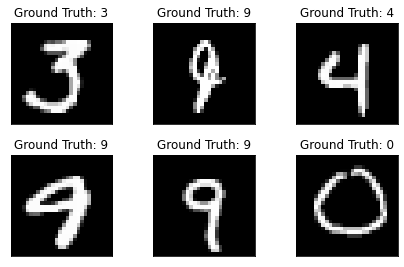

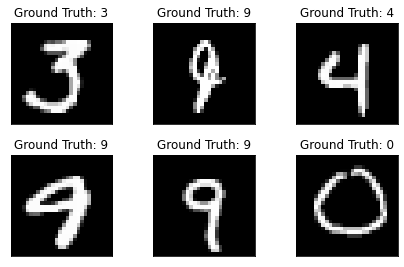

In [ ]:
%%time
epoch = 10
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
softmax_cross_entropy_loss = gluon.loss.SoftmaxCrossEntropyLoss()
for i in range(epoch):
    # Reset the train data iterator.
    train_data.reset()
    # Loop over the train data iterator.
    for batch in train_data:
        # Splits train data into multiple slices along batch_axis
        # and copy each slice into a context.
        data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
        # Splits train labels into multiple slices along batch_axis
        # and copy each slice into a context.
        label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
        outputs = []
        # Inside training scope
        with ag.record():
            for x, y in zip(data, label):
                z = net(x)
                # Computes softmax cross entropy loss.
                loss = softmax_cross_entropy_loss(z, y)
                # Backpropagate the error for one iteration.
                loss.backward()
                outputs.append(z)
        # Updates internal evaluation
        metric.update(label, outputs)
        # Make one step of parameter update. Trainer needs to know the
        # batch size of data to normalize the gradient by 1/batch_size.
        trainer.step(batch.data[0].shape[0])
    # Gets the evaluation result.
    name, acc = metric.get()
    # Reset evaluation result to initial state.
    metric.reset()
    print('training acc at epoch %d: %s=%f'%(i, name, acc))

Prediction
After the above training completes, we can evaluate the trained model by running predictions on validation dataset. Since the dataset also has labels for all test images, we can compute the accuracy metric over validation data as follows:

In [ ]:
# Use Accuracy as the evaluation metric.
metric = mx.metric.Accuracy()
# Reset the validation data iterator.
val_data.reset()
# Loop over the validation data iterator.
for batch in val_data:
    # Splits validation data into multiple slices along batch_axis
    # and copy each slice into a context.
    data = gluon.utils.split_and_load(batch.data[0], ctx_list=ctx, batch_axis=0)
    # Splits validation label into multiple slices along batch_axis
    # and copy each slice into a context.
    label = gluon.utils.split_and_load(batch.label[0], ctx_list=ctx, batch_axis=0)
    outputs = []
    for x in data:
        outputs.append(net(x))
    # Updates internal evaluation
    metric.update(label, outputs)
print('validation acc: %s=%f'%metric.get())
assert metric.get()[1] > 0.94

Jeśli wszystko poszło dobrze, powinniśmy zobaczyć wartość dokładności około 0,96, co oznacza, że jesteśmy w stanie dokładnie przewidzieć cyfrę w 96% obrazów testowych.